In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import sklearn
import sklearn.linear_model
import sklearn.ensemble
import sklearn.metrics
from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward
from testCases_v4a import *
from dnn_app_utils_v3 import *
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from RandomForestModelImprovement import RandomForestModelImprovement
%matplotlib inline

In [2]:
df = pd.read_csv("signate 債務不履行リスク.csv")
#application_appの列でーたを削除
df.drop(columns="application_type", inplace=True)
print('dataframeの行数・列数の確認==>\n', df.shape)
print('indexの確認==>\n', df.index)
print('columnの確認==>\n', df.columns)
print("dataframeの各列のデータ型を確認==>\n", df.dtypes)
#df['loan_status'].unique() #array(['FullyPaid', 'ChargedOff'], dtype=object) onehot
#df.isnull().sum()
#df['term'].unique() array(['3 years', '5 years'], dtype=object) onehot
#df['grade'].unique() array(['A5', 'B1', 'C2', 'C1', 'E5', 'D5', 'B4', 'A3', 'D3', 'C3', 'A2',
                               #'D1', 'A1', 'C5', 'A4', 'C4', 'E4', 'B2', 'B5', 'D2', 'D4', 'B3',
                               #'E2', 'E1', 'E3', 'F3', 'F5'], dtype=object)⇒27parameters
#df['employment_length'].unique() array(['0 years', '10 years', '1 year', '2 years', '3 years', '6 years',
                                        #'9 years', '7 years', '4 years', '5 years', '8 years'],
                                         # dtype=object)
#df['purpose'].unique() array(['debt_consolidation', 'credit_card', 'medical', 'other',
                               #'home_improvement', 'car', 'major_purchase', 'small_business',
                               #'house'], dtype=object) onehot
#df['application_type'].unique() array(['Individual', 'Joint App'], dtype=object) onehot


df = pd.get_dummies(df, columns=['purpose'])

dataframeの行数・列数の確認==>
 (242150, 9)
indexの確認==>
 RangeIndex(start=0, stop=242150, step=1)
columnの確認==>
 Index(['id', 'loan_amnt', 'term', 'interest_rate', 'grade',
       'employment_length', 'purpose', 'credit_score', 'loan_status'],
      dtype='object')
dataframeの各列のデータ型を確認==>
 id                     int64
loan_amnt            float64
term                  object
interest_rate        float64
grade                 object
employment_length     object
purpose               object
credit_score         float64
loan_status           object
dtype: object


In [3]:
loan_status_seri = df["loan_status"]
loan_status_list = loan_status_seri.values.tolist()


loan_status_list2 = []
for loan_status in loan_status_list:
    if loan_status == "FullyPaid":
        loan_status = 0
    else:
        loan_status = 1
    loan_status_list2.append(loan_status)
    
    
loan_status_seri = pd.Series(loan_status_list2)
df["loan_status"] = loan_status_seri

In [4]:
term_seri = df["term"]
term_list = term_seri.values.tolist()


term_list2 =[]
for term in term_list:
    term = term.replace("years", "")
    term = float(term)
    term_list2.append(term)
    
    
term_seri = pd.Series(term_list2)


df["term"] = term_seri

In [5]:
employment_length_seri = df["employment_length"]
employment_length_list = employment_length_seri.values.tolist()


employment_length_list2=[]
for employment_length in employment_length_list:
    if "years" in employment_length:
        employment_length = employment_length.replace("years", "")
        employment_length = float(employment_length)
    else:
        employment_length = employment_length.replace("year", "")
        employment_length = float(employment_length)
    employment_length_list2.append(employment_length)
    
    
employment_length_seri = pd.Series(employment_length_list2)


df["employment_length"] = employment_length_seri
df.head()

,id,loan_amnt,term,interest_rate,grade,employment_length,credit_score,loan_status,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business
0,0,609.296068,3.0,8.421982,A5,0.0,714.061803,0,0,0,1,0,0,0,0,0,0
1,1,1183.266999,5.0,10.286776,B1,10.0,697.706701,1,0,1,0,0,0,0,0,0,0
2,2,695.783256,3.0,14.723425,C2,1.0,656.419357,0,0,0,1,0,0,0,0,0,0
3,3,738.392546,3.0,14.260708,C1,0.0,657.906852,0,0,1,0,0,0,0,0,0,0
4,4,1642.400654,5.0,25.217452,E5,10.0,662.972297,0,0,0,1,0,0,0,0,0,0


In [6]:
def standarize(column):
    df_ = df.copy()
    s = df_[column]
    df_['standardization'] = (s - s.mean()) / s.std()
    df[column] = df_['standardization']
    
    return df


df = standarize("loan_amnt")
df = standarize("interest_rate")
df = standarize("credit_score")
df.head()

,id,loan_amnt,term,interest_rate,grade,employment_length,credit_score,loan_status,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business
0,0,-1.097372,3.0,-1.172282,A5,0.0,1.031534,0,0,0,1,0,0,0,0,0,0
1,1,-0.406049,5.0,-0.765914,B1,10.0,0.478152,1,0,1,0,0,0,0,0,0,0
2,2,-0.993202,3.0,0.200903,C2,1.0,-0.918824,0,0,0,1,0,0,0,0,0,0
3,3,-0.941880,3.0,0.100070,C1,0.0,-0.868494,0,0,1,0,0,0,0,0,0,0
4,4,0.146958,5.0,2.487720,E5,10.0,-0.697103,0,0,0,1,0,0,0,0,0,0


In [7]:
grade_mapping = {'A5':27, 'B1':18, 'C2':14, 'C1':13, 'E5':7, 'D5':12, 'B4':21, 'A3':25, 'D3':10, 'C3':15, 'A2':24,'D1':8, 'A1':23,
                 'C5':17, 'A4':26, 'C4':16, 'E4':6, 'B2':19, 'B5':22, 'D2':9, 'D4':11, 'B3':20,'E2':4, 'E1':3, 'E3':5, 'F3':1, 'F5':2}
df["grade"] = df["grade"].map(grade_mapping)
df.head()

,id,loan_amnt,term,interest_rate,grade,employment_length,credit_score,loan_status,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business
0,0,-1.097372,3.0,-1.172282,27,0.0,1.031534,0,0,0,1,0,0,0,0,0,0
1,1,-0.406049,5.0,-0.765914,18,10.0,0.478152,1,0,1,0,0,0,0,0,0,0
2,2,-0.993202,3.0,0.200903,14,1.0,-0.918824,0,0,0,1,0,0,0,0,0,0
3,3,-0.941880,3.0,0.100070,13,0.0,-0.868494,0,0,1,0,0,0,0,0,0,0
4,4,0.146958,5.0,2.487720,7,10.0,-0.697103,0,0,0,1,0,0,0,0,0,0


(-0.5, 26.5, 0, 1)

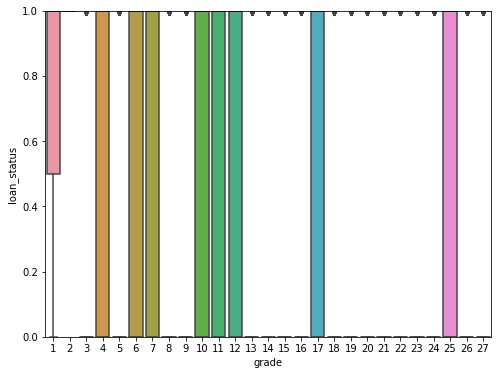

In [9]:
def X_y(df, column):
    y_train = np.array(df[column])
    del df[column]
    del df["id"]
    X_train = df
    return X_train, y_train


X, y = X_y(df, "loan_status")


X_train = X[:230000]
y_train = y[:230000].reshape(-1, 1)

X_val = X[230000:]
y_val = y[230000:].reshape(-1, 1)

In [10]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

C:\Users\lifetime\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
val = rf_classifier.predict(X_val)

In [12]:
val

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [13]:
f1_score(list(y_val.reshape(-1)),val)

0.20355656451002652

In [14]:
def RandomForestClassifierModelImprovement(X_train, y_train, X_val, y_val, max_depthes=[], min_samples_splits=[], min_samples_leafs=[]):
    for max_depth in max_depthes:
        for min_samples_split in min_samples_splits:
            for min_samples_leaf in min_samples_leafs:
                # Define the model. Set random_state to 1
                rf_model = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

                # fit your model
                rf_model.fit(X_train, y_train)

                # Calculate the mean absolute error of your Random Forest model on the validation data
                val = rf_model.predict(X_val)
                rf_val_mae = mean_absolute_error(val, y_val)

                print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))
                
                predict_y_val = rf_model.predict(X_val)
                    
                f1 = f1_score(list(y_val.reshape(-1)),val)
                
                print("max_depth:{}, min_samples_split:{}, min_samples_leaf:{}, f1score:{}".format(max_depth, min_samples_split, min_samples_leaf,f1))   

In [17]:
RandomForestClassifierModelImprovement(X_train, y_train, X_val, y_val, max_depthes=[1000,2000], min_samples_splits=[10,100], min_samples_leafs=[5,10])

C:\Users\lifetime\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Validation MAE for Random Forest Model: 0.1660082304526749
max_depth:1000, min_samples_split:10, min_samples_leaf:5, f1score:0.16824742268041237


C:\Users\lifetime\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Validation MAE for Random Forest Model: 0.16584362139917697
max_depth:1000, min_samples_split:10, min_samples_leaf:10, f1score:0.16076634735526862


C:\Users\lifetime\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Validation MAE for Random Forest Model: 0.1660082304526749
max_depth:1000, min_samples_split:100, min_samples_leaf:5, f1score:0.15853149770546515


C:\Users\lifetime\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Validation MAE for Random Forest Model: 0.1651028806584362
max_depth:1000, min_samples_split:100, min_samples_leaf:10, f1score:0.162771285475793


C:\Users\lifetime\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Validation MAE for Random Forest Model: 0.1654320987654321
max_depth:2000, min_samples_split:10, min_samples_leaf:5, f1score:0.17351973684210525


C:\Users\lifetime\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Validation MAE for Random Forest Model: 0.16650205761316872
max_depth:2000, min_samples_split:10, min_samples_leaf:10, f1score:0.15953469048608226


C:\Users\lifetime\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Validation MAE for Random Forest Model: 0.16576131687242798
max_depth:2000, min_samples_split:100, min_samples_leaf:5, f1score:0.1629260182876143


C:\Users\lifetime\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Validation MAE for Random Forest Model: 0.16551440329218106
max_depth:2000, min_samples_split:100, min_samples_leaf:10, f1score:0.1617340558566069


In [16]:
#Validation MAE for Random Forest Model: 0.1662551440329218
#max_depth:100, min_samples_split:10, min_samples_leaf:10, f1score:0.15763135946622184

#Validation MAE for Random Forest Model: 0.16691358024691358
#max_depth:100, min_samples_split:10, min_samples_leaf:100, f1score:0.11749347258485641

#Validation MAE for Random Forest Model: 0.1702880658436214
#max_depth:100, min_samples_split:10, min_samples_leaf:500, f1score:0.04786010124252186